In [39]:
import pygame, sys, random
import numpy as np
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam
import math
import matplotlib.pyplot as plt
import pylab

num_episodes = 10

agentRadius = 10

# get size of state and action from environment

boundaryPos = [100, 100]
boundaryLength = [100, 100]
initPosAgent = [boundaryPos[0], boundaryPos[1] + boundaryLength[1]]
goalPos = [boundaryPos[0] + boundaryLength[0], boundaryPos[1]]

moveObstacles = False
action_size = 8
obsNumber = 5
# state_size = obsNumber * 2 + 1
state_size = 3
# state_size = obsNumber + 1

In [25]:
# A2C(Advantage Actor-Critic) agent
class A2CAgent:
    def __init__(self, state_size, action_size):
        self.load_model = True
        # get size of state and action
        self.state_size = state_size
        self.action_size = action_size
        self.value_size = 1

        # These are hyper parameters for the Policy Gradient
        self.discount_factor = 0.99
        self.actor_lr = 0.00002
        self.critic_lr = 0.00005

        # create model for policy network
        self.actor = self.build_actor()
        self.critic = self.build_critic()

        if self.load_model:
            self.actor.load_weights("./Practice004_DataSave/Actor.h5")
            self.critic.load_weights("./Practice004_DataSave/Critic.h5")

    # approximate policy and value using Neural Network
    # actor: state is input and probability of each action is output of model
    def build_actor(self):
        actor = Sequential()
        actor.add(Dense(128, input_dim=self.state_size, activation='relu', kernel_initializer='glorot_normal'))
        actor.add(Dense(self.action_size, activation='softmax', kernel_initializer='glorot_normal'))
        actor.summary()
        # See note regarding crossentropy in cartpole_reinforce.py
        actor.compile(loss='categorical_crossentropy', optimizer=Adam(lr=self.actor_lr))
        return actor

    # critic: state is input and value of state is output of model
    def build_critic(self):
        critic = Sequential()
        critic.add(Dense(128, input_dim=self.state_size, activation='relu', kernel_initializer='glorot_normal'))
        critic.add(Dense(self.value_size, activation='linear', kernel_initializer='glorot_normal'))
        critic.summary()
        critic.compile(loss="mse", optimizer=Adam(lr=self.critic_lr))
        return critic

    # using the output of policy network, pick action stochastically
    def get_action(self, state):
        policy = self.actor.predict(state, batch_size=1).flatten()
        # Policy = 확률. 이 확률에 맞게 Action을 선택
#         return [np.random.choice(self.action_size, 1, p=policy)[0], np.argmin(policy)]
        return policy

    # update policy network every episode
    def train_model(self, state, action, reward, next_state, done):
        target = np.zeros((1, self.value_size))
        advantages = np.zeros((1, self.action_size))

        value = self.critic.predict(state)[0]
        next_value = self.critic.predict(next_state)[0]

        if done:
            advantages[0][action] = reward - value
            target[0][0] = reward
        else:
            advantages[0][action] = reward + self.discount_factor * (next_value) - value
            target[0][0] = reward + self.discount_factor * next_value

        self.actor.fit(state, advantages, epochs=1, verbose=0)
        self.critic.fit(state, target, epochs=1, verbose=0)

In [10]:
def ckWall(xPos, yPos):
    flagWall = 0
    if(xPos < boundaryPos[0]):
        xPos = boundaryPos[0]
        flagWall = -1
    elif(xPos > boundaryPos[0] + boundaryLength[0]):
        xPos = boundaryPos[0] + boundaryLength[0]
        flagWall = -1
    if(yPos < boundaryPos[1]):
        yPos = boundaryPos[1]
        flagWall = -1
    elif(yPos > boundaryPos[1] + boundaryLength[1]):
        yPos = boundaryPos[1] + boundaryLength[1]
        flagWall = -1
        
    return [xPos, yPos, flagWall]

In [11]:
def ckInit(initLoc, obsLoc):
    if math.sqrt((initLoc[0] - obsLoc[0])**2 + (initLoc[1] - obsLoc[1])**2) <= 2*agentRadius + 1:
        if initLoc[0] - obsLoc[0] < 0:
            obsLoc[0] += 1
        else:
            obsLoc[0] -= 1
        if initLoc[1] - obsLoc[1] < 0:
            obsLoc[1] += 1
        else:
            obsLoc[1] -= 1
    if math.sqrt((goalPos[0] - obsLoc[0])**2 + (goalPos[1] - obsLoc[1])**2) <= 2*agentRadius + 1:
        obsLoc[0] -= 1
        obsLoc[1] += 1
    return obsLoc

In [15]:
def stateGenerator(obsPosition, agtPosition, idx):
    returnSum = []
    returnSum = returnSum + [agtPosition[0] - obsPosition[idx][0], agtPosition[1] - obsPosition[idx][1]]
    returnSum = returnSum + [math.sqrt((agtPosition[0] - goalPos[0])**2 + (agtPosition[1] - goalPos[1])**2)]
    returnSum = np.reshape(returnSum, [1, 3])
    return returnSum

In [13]:
def takeAction(action):
    xAction = 0
    yAction = 0
    if action == 0:
        xAction = 1
    elif action == 1:
        xAction = 1
        yAction = 1
    elif action == 2:
        xAction = 1
        yAction = -1            
    elif action == 3:
        xAction = -1
        yAction = 1
    elif action == 4:
        xAction = -1
    elif action == 5:
        xAction = -1
        yAction = -1
    elif action == 6:
        yAction = -1
    elif action == 7:
        yAction = 1
        
    return [xAction, yAction]

In [40]:
pygame.init()
screen = pygame.display.set_mode([1280,960])
screen.fill([200, 200, 200])

# make A2C agent
agent = A2CAgent(state_size, action_size)

rList, episodes = [], []

# Make Obstacles (obsNumber)
obstaclePos = [[0, 0] for _ in range(obsNumber)]
for i in range(0,obsNumber):
    while True:
        obstaclePos[i][0] = boundaryPos[0] + random.randrange(1, boundaryLength[0])
        obstaclePos[i][1] = boundaryPos[1] + random.randrange(1, boundaryLength[1])
        if obstaclePos[i][0] <= goalPos[0] - agentRadius or obstaclePos[i][0] >= goalPos[0] + agentRadius:
            if obstaclePos[i][1] >= goalPos[1] + agentRadius or obstaclePos[i][1] <= goalPos[1] - agentRadius:
                if obstaclePos[i][0] <= initPosAgent[0] - agentRadius or obstaclePos[i][0] >= initPosAgent[0] + agentRadius:
                    if obstaclePos[i][1] >= initPosAgent[1] + agentRadius or obstaclePos[i][1] <= initPosAgent[1] - agentRadius:
                        break

for e in range(num_episodes):
    # Initialize
    done = False
    score = 0
    x = initPosAgent[0]#boundaryPos[0]
    y = initPosAgent[1]#boundaryPos[1]
    print("Episode ", e, "Starts!")
    #state = np.reshape(state, [1, state_size])

    while not done:
#         tmpBadActionList = []
#         tmpActionList = []
        getPolicy = []
        tmpPolicyA = []
        tmpPolicyB = []
        for i in range(0, obsNumber):
            state = stateGenerator(obstaclePos, [x,y], i)
#             [action, badAction] = agent.get_action(state)
#             tmpActionList = tmpActionList + [action]
#             tmpBadActionList = tmpBadActionList + [badAction]
            tmpPolicyA = agent.get_action(state)
            if(i > 0):
                getPolicy = np.multiply(tmpPolicyA, tmpPolicyB)
            tmpPolicyB = tmpPolicyA
        getPolicy = getPolicy / sum(getPolicy)
        action = np.random.choice(action_size, 1, p = getPolicy)[0]
        
        xMove = 0
        yMove = 0
        
        [xMove, yMove] = takeAction(action)
        
        x = x + xMove
        y = y + yMove

        wallFlag = 0
        collisionFlag = 0
        [x, y, wallFlag] = ckWall(x,y)
        pygame.draw.circle(screen, [100, 100, 255], [x,y], 10, 0)
#         next_state = stateGenerator(obstaclePos, [x,y])

        if(math.sqrt((x - goalPos[0])**2 + (y - goalPos[1])**2) <= 20):
            print("Goal Reached!")           
            collisionFlag = 1
            done = 1
        for i in range(0,obsNumber):
            if moveObstacles:
                obstaclePos[i][0] = obstaclePos[i][0] + random.randrange(-1,2)
                obstaclePos[i][1] = obstaclePos[i][1] + random.randrange(-1,2)
                [obstaclePos[i][0], obstaclePos[i][1], _] = ckWall(obstaclePos[i][0], obstaclePos[i][1])
                obstaclePos[i] = ckInit(initPosAgent ,obstaclePos[i])

            pygame.draw.circle(screen, [255, 50, 50], obstaclePos[i], 10, 0)
            if math.sqrt((x - obstaclePos[i][0])**2 + (y - obstaclePos[i][1])**2) <= 20:
                print("Collision!")
                collisionFlag = -1
                ObjectIndex = i
                done = True 
#         if wallFlag == -1:
#             done = True
            
        if not done:
            reward = -0.1
            if wallFlag == -1:
                reward = -1
        else:
            if collisionFlag == 1:
                reward = 10000
                rList.append(1)
            elif collisionFlag == -1:
                reward = -10000
                rList.append(0)
#             next_state, reward, done, ininitPosAgentfo = env.step(action)
#             next_state = np.reshape(next_state, [1, state_size])
        # if an action make the episode end, then gives penalty of -100
#             reward = reward if not done or score == 499 else -100
        
#         agent.train_model(state, action, reward, next_state, done)

        score += reward
#         state = next_state

        if done:
            # every episode, plot the play time

            episodes.append(e)
            pylab.plot(episodes, rList, 'b')
            pylab.savefig("./Practice004_DataSave/ActorCriticGraph_Test.png")
        #circle(Surface, color, pos, radius, width=0)
        pygame.draw.circle(screen, [100,255,100], [goalPos[0],goalPos[1]], 10, 2)
        #rect(Surface, color, Rect, width=0)
        pygame.draw.rect(screen, [255,100,100],[boundaryPos[0] - agentRadius, boundaryPos[1] - agentRadius, boundaryLength[0] + agentRadius * 2, boundaryLength[1] + agentRadius * 2],2)
        pygame.display.flip()
        screen.fill([200,200,200])
    print score
    # save the model
#     if e % 50 == 0:
#         agent.actor.save_weights("./Practice004_DataSave/Actor.h5")
#         agent.critic.save_weights("./Practice004_DataSave/Critic.h5")


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_73 (Dense)             (None, 128)               512       
_________________________________________________________________
dense_74 (Dense)             (None, 8)                 1032      
Total params: 1,544
Trainable params: 1,544
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_75 (Dense)             (None, 128)               512       
_________________________________________________________________
dense_76 (Dense)             (None, 1)                 129       
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________
('Episode ', 0, 'Starts!')
Collision!
-10037.2
('Episode ', 1, 'Starts!')
Co

Percent of successful episodes: 100.0%


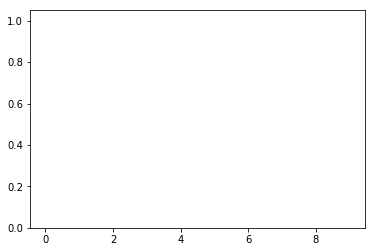

In [34]:
print("Percent of successful episodes: " + str(100.0 * sum(rList)/num_episodes) + "%")

plt.bar(range(len(rList)), rList, color = "Blue", width = 0.00001)
plt.show()